# 1. Importing modules and functions

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import chembl_structure_pipeline
from molvs import standardize_smiles
import shap
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# 2.Data entry and curation work set

In [2]:
uploaded_file_ws="datasets/HDAC2_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  1288 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [3]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [5]:
len(y_tr)

1288

# 3.Standardization SDF file for work set

In [6]:
records_ws = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToMolBlock(all_mols_ws[i])
    records_ws.append(record)
            
mols_ws = []
for i,record in enumerate(records_ws):
    standard_record = chembl_structure_pipeline.standardize_molblock(record)
    m = Chem.MolFromMolBlock(standard_record)
    mols_ws.append(m)
           
moldf_ws = []
for val in mols_ws:
    if val != None:
        moldf_ws.append(val)
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  1288 molecules


# 4.Data entry and curation test set

In [7]:
uploaded_file_ts="datasets/HDAC2_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  323 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [8]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [9]:
len(y_ts)

323

# 5.Standardization SDF file for test set

In [10]:
records_ts = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToMolBlock(all_mols_ts[i])
    records_ts.append(record)
            
mols_ts = []
for i,record in enumerate(records_ts):
    standard_record = chembl_structure_pipeline.standardize_molblock(record)
    m = Chem.MolFromMolBlock(standard_record)
    mols_ts.append(m)
           
moldf_ts = []
for val in mols_ts:
    if val != None:
        moldf_ts.append(val)
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  323 molecules


# 6.Calculation RDKit descriptors for work set

In [11]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()

In [12]:
descr_tr= []
for m in moldf_ws:
    descr_tr.append(calc.CalcDescriptors(m))
x_tr = np.asarray(descr_tr)

In [13]:
df_RDKit_2D_ws = pd.DataFrame(x_tr,columns=header)

In [14]:
df_RDKit_2D_ws.head(2)

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.455473,-0.357127,11.455473,0.103814,0.626907,340.423,316.231,340.178693,132.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.104336,-1.215299,12.104336,0.050219,0.593464,304.327,292.231,304.051778,108.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
x_tr.shape

(1288, 208)

In [16]:
descriptors_list = [x[0] for x in Descriptors._descList]
print(descriptors_list)
len(descriptors_list)

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

208

In [17]:
df_RDKit_2D_ws.to_csv('matrix_descriptors.csv')

# 7.Calculation RDKit descriptors for test set

In [18]:
descr_ts = []
for m in mols_ts:
    descr_ts.append(calc.CalcDescriptors(m))
x_ts = np.asarray(descr_ts)

In [19]:
df_RDKit_2D_ts=pd.DataFrame(x_ts,columns=header)
df_RDKit_2D_ts

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.711660,-0.356723,11.711660,0.008491,0.283266,305.378,282.194,305.173942,120.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
1,11.711040,-0.474139,11.711040,0.303493,0.379909,445.644,402.300,445.319209,180.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,12.169091,-0.310450,12.169091,0.080479,0.093760,495.540,466.308,495.223017,190.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3,11.917176,-0.088943,11.917176,0.035868,0.533121,294.763,283.675,294.022976,98.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.830155,-0.284330,11.830155,0.022034,0.303200,334.460,304.220,334.225643,134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,13.410273,-1.088864,13.410273,0.076195,0.251331,560.723,532.499,560.122183,196.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
319,11.357576,-0.604141,11.357576,0.239604,0.437756,394.479,368.271,394.211724,152.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320,12.321194,-0.377470,12.321194,0.111475,0.264777,350.418,328.242,350.163043,134.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
321,12.483399,-3.629773,12.483399,0.147388,0.322146,399.472,378.304,399.125277,146.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
x_ts.shape

(323, 208)

# 8. Random forest: model building and validation

In [22]:
seed = 42

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
param_grid = {"max_features": [x_tr.shape[1] // 10, x_tr.shape[1] // 7, x_tr.shape[1] // 5, x_tr.shape[1] // 3, x_tr.shape[1] // 2],
              "n_estimators": [100, 250, 500, 1000]}

In [22]:
m = GridSearchCV(RandomForestRegressor(), param_grid, n_jobs=2, cv=cv, verbose=1)

In [23]:
m.fit(x_tr, y_tr)

The least populated class in y has only 1 members, which is less than n_splits=5.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=2,
             param_grid={'max_features': [20, 29, 41, 69, 104],
                         'n_estimators': [100, 250, 500, 1000]},
             verbose=1)

In [24]:
m.best_params_
best_RF_rdkit = m.best_estimator_

In [24]:
y_pred_CV_RF = cross_val_predict(best_RF_rdkit, x_tr, y_tr, cv=cv)

The least populated class in y has only 1 members, which is less than n_splits=5.


In [25]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_RF), 2)
Q2_CV

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


0.52

In [26]:
RMSE_CV=np.sqrt(mean_absolute_error(y_tr, y_pred_CV_RF))
RMSE_CV

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


0.7536301975772407

# 9. Prediction for test set's molecules

In [27]:
y_pred_rf = best_RF_rdkit.predict(x_ts)

In [28]:
Q2_TS = r2_score(y_ts, y_pred_rf)
Q2_TS

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


0.5843440487980145

In [29]:
RMSE_TS=np.sqrt(mean_absolute_error(y_ts, y_pred_rf))
RMSE_TS

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


0.7253347159405832

# save the model to disk

In [33]:
pickle.dump(best_RF_rdkit, open('Models/RDKit/HDAC2_RF_RDKit.pkl', 'wb'))

# load the model from disk

In [20]:
best_RF_rdkit = pickle.load(open('Models/RDKit/HDAC2_RF_RDKit.pkl', 'rb'))

# 10. Y-randomization RF model

In [35]:
permutations = 100
score, permutation_scores, pvalue = permutation_test_score(best_RF_rdkit, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=24)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

The least populated class in y has only 1 members, which is less than n_splits=5.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays

True score =  0.52 
Y-randomization =  -0.11 
p-value =  0.0099


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 37.8min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [30]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [31]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.994966e+03,1.390429e+03,5.688260e+04,7.799846e+04,5.075431e+01,9.860640e+03,7.816679e+06,1.454380e+03,1.521655e+05,2.342090e+02,...,7.838367e+01,2.801339e+01,1.078334e+04,2.281934e+08,3.293369e+07,7.407520e+07,4.699368e+13,2.801339e+01,1.502977e+09,5.174541e+09
2,2.974269e+03,3.708921e+03,6.901245e+04,1.295078e+05,5.075431e+01,9.860677e+03,5.432975e+07,1.554965e+03,2.880110e+05,3.527916e+02,...,6.491218e+06,3.458685e+01,3.812089e+05,2.801606e+08,3.928788e+08,9.521612e+07,6.773929e+13,3.724245e+01,2.043875e+09,1.028494e+10
3,2.975838e+03,3.835224e+03,6.901249e+04,1.408315e+05,3.059131e+06,1.145269e+04,5.538778e+07,2.912426e+03,8.613651e+05,5.630919e+02,...,1.427392e+07,3.028918e+03,6.814503e+05,8.808838e+08,5.158469e+08,1.271219e+08,6.912743e+13,3.029046e+03,2.305176e+09,1.051756e+10
4,4.079183e+03,4.295784e+03,1.266691e+05,1.512752e+05,6.861558e+06,1.378231e+04,6.621962e+07,5.543377e+03,9.100314e+05,5.938791e+02,...,3.073986e+07,3.071703e+05,1.504395e+06,1.026581e+09,5.760263e+08,1.494598e+08,7.062257e+13,3.071703e+05,2.313411e+09,1.131540e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,8.501079e+12,8.501079e+12,8.501066e+12,8.501071e+12,8.500757e+12,8.501078e+12,8.499182e+12,8.501079e+12,8.501023e+12,8.501079e+12,...,8.497578e+12,8.501045e+12,8.501031e+12,8.491768e+12,8.494466e+12,8.498504e+12,7.762851e+13,8.501045e+12,8.481375e+12,8.452455e+12
1284,9.889220e+12,9.889221e+12,9.889208e+12,9.889213e+12,9.888898e+12,9.889220e+12,9.887324e+12,9.889220e+12,9.889164e+12,9.889221e+12,...,9.885720e+12,9.889186e+12,9.889173e+12,9.879909e+12,9.882608e+12,9.886646e+12,7.762851e+13,9.889186e+12,9.869517e+12,9.840597e+12
1285,3.063483e+13,3.063483e+13,3.063482e+13,3.063483e+13,3.063451e+13,3.063483e+13,3.063294e+13,3.063483e+13,3.063478e+13,3.063483e+13,...,3.063133e+13,3.063480e+13,3.063479e+13,3.062552e+13,3.062822e+13,3.063226e+13,7.762851e+13,3.063480e+13,3.061513e+13,3.058621e+13
1286,7.762851e+13,7.762851e+13,7.762850e+13,7.762851e+13,7.762819e+13,7.762851e+13,7.762662e+13,7.762851e+13,7.762846e+13,7.762851e+13,...,7.762501e+13,7.762848e+13,7.762847e+13,7.761920e+13,7.762190e+13,7.762594e+13,7.762851e+13,7.762848e+13,7.760881e+13,7.757989e+13


In [32]:
similarity= neighbors_k

In [33]:
Dmean=np.mean(similarity[1,:])

In [34]:
round(Dmean, 2)

1.0195625640833346e+16

In [35]:
std=np.std(similarity[1,:])

In [36]:
round(std, 2)

3.657638308276831e+17

In [37]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

1.9307754105467485e+17


In [38]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [39]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,313,314,315,316,317,318,319,320,321,322
0,2.459958e+02,1.825777e+04,1.140724e+06,2.333170e+02,5.729071e+02,1.228001e+05,2.360112e+09,6.265686e+02,8.562572e+01,3.200000e+01,...,6.976239e+05,4.108052e+04,1.505055e+02,2.526361e+01,3.412015e+07,2.455620e+06,1.665266e+04,1.270117e+03,8.278527e+03,1.280000e+02
1,2.828401e+02,1.825888e+04,1.246566e+06,2.415339e+02,6.399994e+03,1.408416e+05,2.732025e+09,1.197535e+03,5.507160e+02,9.175920e+06,...,1.026340e+06,2.027638e+05,2.574010e+02,4.129240e+01,3.526988e+07,2.455620e+06,1.371639e+05,2.448417e+03,1.615469e+04,3.293369e+07
2,5.983115e+02,2.415196e+04,1.785130e+06,6.068228e+02,7.521654e+03,2.018132e+05,3.080507e+09,1.198620e+03,1.057115e+03,1.269551e+07,...,6.291824e+06,3.933458e+05,5.165907e+02,6.901250e+04,3.874638e+07,3.096349e+06,1.371639e+05,5.066785e+03,3.685525e+04,3.928788e+08
3,1.018417e+03,3.406008e+05,2.360536e+06,8.539538e+02,9.814667e+03,2.501932e+05,3.173976e+09,1.480909e+03,1.111226e+03,1.476277e+07,...,6.406736e+06,4.313753e+05,3.463796e+03,1.258947e+05,4.341060e+07,3.668245e+06,1.371639e+05,1.722441e+04,4.790774e+04,5.158469e+08
4,4.201751e+03,3.823173e+05,2.363344e+06,8.551783e+02,9.814738e+03,2.619308e+05,3.709512e+09,1.626199e+03,1.845217e+03,2.274264e+07,...,8.932349e+06,4.396674e+05,7.923723e+03,1.956815e+05,4.399809e+07,5.982257e+06,2.235924e+05,1.891250e+04,4.826649e+04,5.760263e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,8.501079e+12,8.501067e+12,8.501000e+12,8.501079e+12,8.501079e+12,8.501075e+12,8.486593e+12,8.501079e+12,8.501079e+12,8.500005e+12,...,8.500813e+12,8.501049e+12,8.501079e+12,8.501066e+12,8.499849e+12,8.500873e+12,8.501073e+12,8.501078e+12,8.501077e+12,8.494466e+12
1284,9.889221e+12,9.889209e+12,9.889141e+12,9.889221e+12,9.889220e+12,9.889217e+12,9.874735e+12,9.889221e+12,9.889221e+12,9.888147e+12,...,9.888954e+12,9.889191e+12,9.889220e+12,9.889208e+12,9.887990e+12,9.889014e+12,9.889214e+12,9.889220e+12,9.889218e+12,9.882608e+12
1285,3.063483e+13,3.063482e+13,3.063475e+13,3.063483e+13,3.063483e+13,3.063483e+13,3.062035e+13,3.063483e+13,3.063483e+13,3.063376e+13,...,3.063457e+13,3.063480e+13,3.063483e+13,3.063482e+13,3.063360e+13,3.063463e+13,3.063483e+13,3.063483e+13,3.063483e+13,3.062822e+13
1286,7.762851e+13,7.762850e+13,7.762843e+13,7.762851e+13,7.762851e+13,7.762851e+13,7.761403e+13,7.762851e+13,7.762851e+13,7.762744e+13,...,7.762825e+13,7.762848e+13,7.762851e+13,7.762850e+13,7.762728e+13,7.762831e+13,7.762851e+13,7.762851e+13,7.762851e+13,7.762190e+13


In [40]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[2.45996000e+02 1.82577680e+04 1.14072406e+06 2.33317000e+02
 5.72907000e+02 1.22800124e+05 2.36011245e+09 6.26569000e+02
 8.56260000e+01 3.20000000e+01 3.05461218e+06 1.11167600e+03
 3.58473000e+02 5.55347300e+03 1.10851000e+02 1.35698350e+04
 5.31120000e+01 5.54257000e+02 8.86404430e+05 4.53356000e+02
 1.11183790e+04 7.88279000e+02 3.51999600e+03 2.63125000e+02
 1.48550900e+03 1.68735000e+02 6.43119678e+05 2.14341000e+03
 2.21441361e+07 3.61242700e+03 2.44129704e+05 1.62476000e+02
 1.39283000e+02 5.61788771e+05 4.61250000e+01 4.53120000e+01
 5.57530000e+01 3.05461218e+06 2.09505000e+03 3.10820000e+01
 4.61625707e+05 1.34125000e+02 5.98914300e+03 4.94010000e+01
 2.56487000e+02 1.89669118e+05 4.73029790e+04 4.46461442e+06
 5.01340930e+04 4.74275000e+02 3.21919380e+04 2.21752000e+02
 3.75710894e+05 7.98530000e+02 2.68964000e+02 2.76680000e+01
 8.28038000e+02 1.05164120e+04 5.01340930e+04 1.05085520e+04
 2.38667965e+05 2.34096200e+03 3.41553078e+05 3.75230000e+01
 1.39898770e+04 1.953660

In [41]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [42]:
print("Coverage = ", sum(cpd_AD) / len(cpd_AD))

Coverage =  0.9938080495356038


In [43]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 23

In [44]:
out_Ad=list(np.where(cpd_AD == 0)[0])
out_Ad

[105, 123]

# 12. Prediction only for molecules included in AD

In [45]:
y_pred_rf_ad=list(y_pred_rf)

In [46]:
y_pred_rf_ad[:] = [x for i,x in enumerate(y_pred_rf_ad) if i not in out_Ad]

In [47]:
len(y_pred_rf_ad)

321

In [48]:
y_ts_ad=list(y_ts)
len(y_ts)

323

In [49]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [50]:
len(y_ts_ad)

321

In [51]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_rf_ad), 2)
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_rf_ad)), 2)
Q2_TS

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.


0.59

In [61]:
RMSE_TS

0.73

# 13.Analysis of the importance of descriptors for the RF model

Using 1288 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/323 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


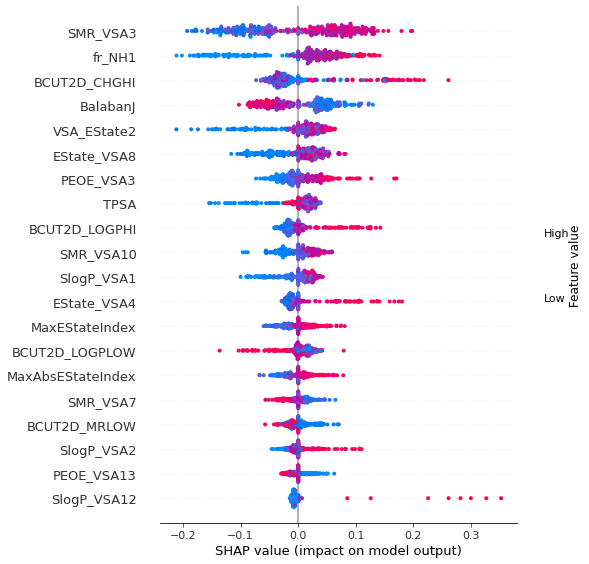

In [63]:
explainer = shap.KernelExplainer(best_RF_rdkit.predict, df_RDKit_2D_ws)
shap_values = explainer.shap_values(df_RDKit_2D_ts)
shap.summary_plot(shap_values, df_RDKit_2D_ts)

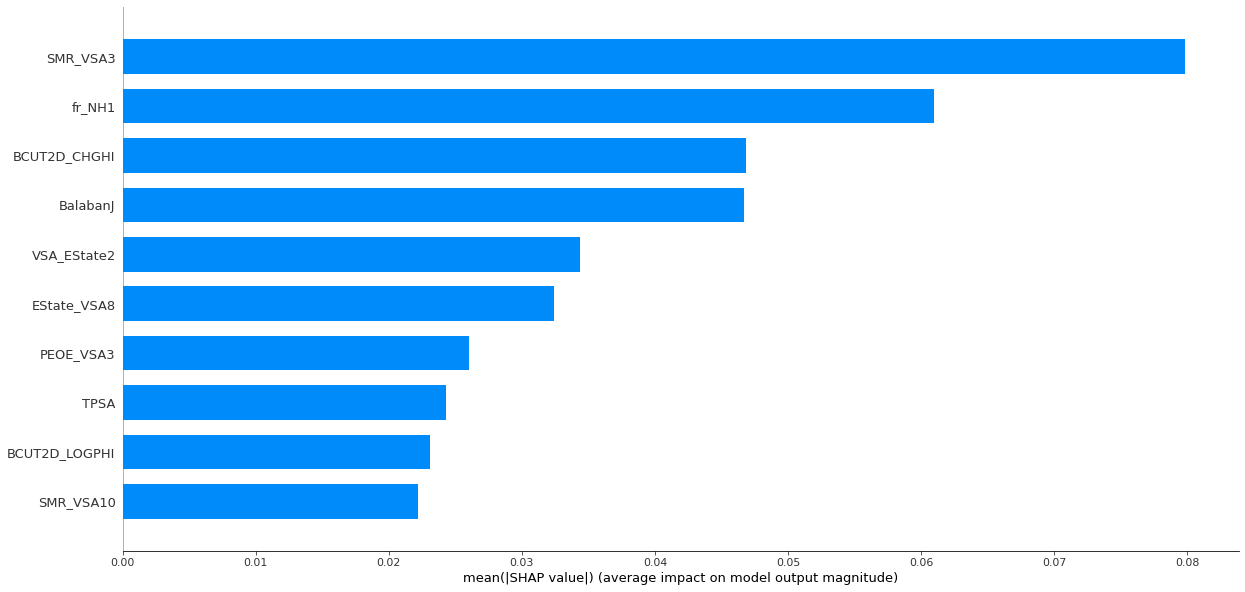

In [66]:
shap.summary_plot(shap_values, df_RDKit_2D_ts, plot_type="bar", plot_size=(20,10), max_display=10)